In [11]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Exploratory Data Analysis with the Data Science Agent in BigQuery

This task covers some out of the box exploratory data analysis possible with the data science agent in Colab.

**Note:**
The features showcased use LLMs and the results are not deterministic. Also, there may be extremely minor Python errors that need fixing - especially print statements. Some of the methods used are at times simplistic.


## 1. Create a curated table that combines multiple tables

Add a code cell and click on "generate" and paste the following prompt and execute the code generated by the Data Science Agent. <br>

**Note:** <br>
Check for errors when it comes to print statements having a new line character and be prepared to fix the same.

`Create or replace a table that combines - (1) product_id, product_nm from product_master table, with (2) customer_id from customer_master table with (3) pos_transactions and (4) pos_transaction_items tables from the dataset rscw_oltp_stg_ds. Call the table customer_purchases_history and persist it to the BQ  dataset rscw_ml_ds. Be sure to include product_nm and customer_id columns.`

In [17]:
# prompt: Create or replace a table that combines - (1) product_id, product_nm from product_master table, with (2) customer_id from customer_master table with (3) pos_transactions and (4) pos_transaction_items tables from the dataset rscw_oltp_stg_ds. Call the table customer_purchases_history and persist it to the BQ dataset rscw_ml_ds. Be sure to include product_nm and customer_id columns.

from google.cloud import bigquery

client = bigquery.Client()

project_id = 'qwiklabs-gcp-04-e2a62eed5a2c'

# Removed destination and write_disposition from job_config as CREATE OR REPLACE TABLE handles it.
job_config = bigquery.QueryJobConfig(
    # destination=f"{project_id}.rscw_ml_ds.customer_purchases_history", write_disposition="WRITE_TRUNCATE"
)

sql = """
CREATE OR REPLACE TABLE rscw_ml_ds.customer_purchases_history AS
SELECT
    t.transaction_id,
    t.transaction_date,
    t.customer_id,
    ti.product_id,
    ti.quantity,
    ti.price,
    p.product_nm
FROM
    rscw_oltp_stg_ds.pos_transactions AS t
JOIN
    rscw_oltp_stg_ds.pos_transaction_items AS ti
    ON t.transaction_id = ti.transaction_id
JOIN
    rscw_oltp_stg_ds.product_master AS p
    ON ti.product_id = p.product_id
"""

query_job = client.query(sql, job_config=job_config)
query_job.result()

print(
    "Table rscw_ml_ds.customer_purchases_history created/replaced successfully."
)

BadRequest: 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/qwiklabs-gcp-04-e2a62eed5a2c/queries/7403a124-23a9-4115-b985-3b829ecf5278?maxResults=0&location=us-central1&prettyPrint=false: Name transaction_date not found inside t at [5:7]

Location: us-central1
Job ID: 7403a124-23a9-4115-b985-3b829ecf5278


## 2. Create a Pandas dataframe that we will reuse for the remainder of the lab module

In [15]:
import pandas as pd
import pandas_gbq

project_id = 'qwiklabs-gcp-04-e2a62eed5a2c'
df_customer_purchases = pandas_gbq.read_gbq("select * from rscw_ml_ds.customer_purchases_history", project_id=project_id)

GenericGBQException: Reason: 404 POST https://bigquery.googleapis.com/bigquery/v2/projects/qwiklabs-gcp-04-e2a62eed5a2c/queries?prettyPrint=false: Not found: Table qwiklabs-gcp-04-e2a62eed5a2c:rscw_ml_ds.customer_purchases_history was not found in location us-central1

In [ ]:
# @title


## 3. Run OOTB Exploratory Data Analytics (EDA) against the table with Data Science Agent's help

Add a code cell and click on "generate" and paste the following prompt and execute the code generated by the Data Science Agent. <br>

**Note:** <br>
Check for errors when it comes to print statements having a new line character and be prepared to fix the same.

`You are an expert data analyst and data engineer. Run EDA on the dataframe df_customer_purchases. Note that all data is for a single state code - IL, where you would have run analysis on state code, run for city. Display charts where meaningful. Dont present any incomplete code. Ensure code presented is syntactically correct. Also, dont present any incomplete code. Generate code less than 100 lines of code
`

In [ ]:
# prompt: You are an expert data analyst and data engineer. Run EDA on the dataframe df_customer_purchases. Note that all data is for a single state code - IL, where you would have run analysis on state code, run for city. Display charts where meaningful. Dont present any incomplete code. Ensure code presented is syntactically correct. Also, dont present any incomplete code. Generate code less than 100 lines of code

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information about the dataframe
print("Dataframe Info:")
df_customer_purchases.info()
print("
")

# Display descriptive statistics
print("Descriptive Statistics:")
print(df_customer_purchases.describe())
print("
")

# Check for missing values
print("Missing Values:")
print(df_customer_purchases.isnull().sum())
print("
")

# Convert 'transaction_date' to datetime objects
df_customer_purchases['transaction_date'] = pd.to_datetime(df_customer_purchases['transaction_date'])

# Analyze sales over time
df_customer_purchases['sales'] = df_customer_purchases['quantity'] * df_customer_purchases['price']
sales_over_time = df_customer_purchases.groupby(df_customer_purchases['transaction_date'].dt.to_period('M'))['sales'].sum()
sales_over_time.index = sales_over_time.index.astype(str) # Convert PeriodIndex to string for plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=sales_over_time.index, y=sales_over_time.values)
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 products by sales
top_products = df_customer_purchases.groupby('product_nm')['sales'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

# Top 10 customers by sales
top_customers = df_customer_purchases.groupby('customer_id')['sales'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_customers.values, y=top_customers.index.astype(str))
plt.title('Top 10 Customers by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()

# Distribution of quantity
plt.figure(figsize=(8, 5))
sns.histplot(df_customer_purchases['quantity'], bins=20, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Distribution of price
plt.figure(figsize=(8, 5))
sns.histplot(df_customer_purchases['price'], bins=20, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 3. Detect outliers with Data Science Agent's help

Add a code cell and click on "generate" and paste the following prompt and execute the code generated by the Data Science Agent. <br>

**Note:** <br>
Check for errors when it comes to print statements having a new line character and be prepared to fix the same.

`Identify any outliers in the data in dataframe df_customer_purchases`

In [ ]:
# prompt: Identify any outliers in the data in dataframe df_customer_purchases

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Outlier detection using IQR for 'quantity'
Q1_quantity = df_customer_purchases['quantity'].quantile(0.25)
Q3_quantity = df_customer_purchases['quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity
outlier_threshold_upper_quantity = Q3_quantity + 1.5 * IQR_quantity
outlier_threshold_lower_quantity = Q1_quantity - 1.5 * IQR_quantity

outliers_quantity = df_customer_purchases[(df_customer_purchases['quantity'] < outlier_threshold_lower_quantity) | (df_customer_purchases['quantity'] > outlier_threshold_upper_quantity)]

print("Outliers in 'quantity' column:")
print(outliers_quantity[['transaction_id', 'product_nm', 'quantity']])
print("
")

# Visualize outliers in 'quantity' using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_customer_purchases['quantity'])
plt.title('Box Plot of Quantity')
plt.ylabel('Quantity')
plt.show()

# Outlier detection using IQR for 'price'
Q1_price = df_customer_purchases['price'].quantile(0.25)
Q3_price = df_customer_purchases['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outlier_threshold_upper_price = Q3_price + 1.5 * IQR_price
outlier_threshold_lower_price = Q1_price - 1.5 * IQR_price

outliers_price = df_customer_purchases[(df_customer_purchases['price'] < outlier_threshold_lower_price) | (df_customer_purchases['price'] > outlier_threshold_upper_price)]

print("Outliers in 'price' column:")
print(outliers_price[['transaction_id', 'product_nm', 'price']])
print("
")

# Visualize outliers in 'price' using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_customer_purchases['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()

# Outlier detection using IQR for 'sales' (if 'sales' column exists from previous steps)
if 'sales' in df_customer_purchases.columns:
    Q1_sales = df_customer_purchases['sales'].quantile(0.25)
    Q3_sales = df_customer_purchases['sales'].quantile(0.75)
    IQR_sales = Q3_sales - Q1_sales
    outlier_threshold_upper_sales = Q3_sales + 1.5 * IQR_sales
    outlier_threshold_lower_sales = Q1_sales - 1.5 * IQR_sales

    outliers_sales = df_customer_purchases[(df_customer_purchases['sales'] < outlier_threshold_lower_sales) | (df_customer_purchases['sales'] > outlier_threshold_upper_sales)]

    print("Outliers in 'sales' column:")
    print(outliers_sales[['transaction_id', 'product_nm', 'quantity', 'price', 'sales']])
    print("
")

    # Visualize outliers in 'sales' using a box plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df_customer_purchases['sales'])
    plt.title('Box Plot of Sales')
    plt.ylabel('Sales')
    plt.show()
else:
    print("The 'sales' column was not found. Please ensure it's created before running outlier detection on it.")

## 4. Detect missing values with Data Science Agent's help

Add a code cell and click on "generate" and paste the following prompt and execute the code generated by the Data Science Agent. <br>

**Note:** <br>
Check for errors when it comes to print statements having a new line character and be prepared to fix the same.

`Identify any missing values in the data in dataframe df_customer_purchases and suggest replacement values`

In [ ]:
# prompt: Identify any missing values in the data in dataframe df_customer_purchases and suggest replacement values

# Identify missing values
missing_values = df_customer_purchases.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])
print("
")

# Suggest replacement values
print("Suggestions for replacing missing values:")

for column in missing_values[missing_values > 0].index:
    if df_customer_purchases[column].dtype == 'object':
        # For categorical columns, suggest mode
        mode_val = df_customer_purchases[column].mode()[0]
        print(f"- Column '{column}': Replace with mode ('{mode_val}') or a placeholder like 'Unknown'.")
    elif df_customer_purchases[column].dtype in ['int64', 'float64']:
        # For numerical columns, suggest mean, median, or 0
        mean_val = df_customer_purchases[column].mean()
        median_val = df_customer_purchases[column].median()
        print(f"- Column '{column}': Replace with mean ({mean_val:.2f}), median ({median_val:.2f}), or 0 (if applicable).")
    elif df_customer_purchases[column].dtype == 'datetime64[ns]':
        # For datetime columns, suggest forward fill, backward fill, or a specific date
        print(f"- Column '{column}': Consider forward fill (ffill), backward fill (bfill), or a specific default date.")

## 5. Detect correlations between numerical features with Data Science Agent's help

Add a code cell and click on "generate" and paste the following prompt and execute the code generated by the Data Science Agent. <br>

**Note:** <br>
Check for errors when it comes to print statements having a new line character and be prepared to fix the same.

`Show me the correlations between numerical features in the data in dataframe df_customer_purchases`

In [ ]:
# prompt: Show me the correlations between numerical features in the data in dataframe df_customer_purchases

import matplotlib.pyplot as plt
# Select only numerical columns for correlation analysis
numerical_df = df_customer_purchases.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

print("Correlation Matrix of Numerical Features:")
print(correlation_matrix)
print("
")

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 6. Explore the distribution of customers with Data Science Agent's help

Add a code cell and click on "generate" and paste the following prompt and execute the code generated by the Data Science Agent. <br>

**Note:** <br>
Check for errors when it comes to print statements having a new line character and be prepared to fix the same.

`Show me the distribution of customers by city, distribution of customers by spend in the data in dataframe df_customer_purchases, render as piechart. Dont generate code greater than 95 lines.`

In [ ]:
# prompt: Show me the distribution of customers by city, distribution of customers by spend in the data in dataframe df_customer_purchases, render as piechart. Dont generate code greater than 95 lines.

import pandas as pd
import matplotlib.pyplot as plt
# For customer distribution by city, we need city information.
# Assuming 'customer_id' can be linked to city information from another source or if it's implicitly available.
# Since the prompt mentions "all data is for a single state code - IL, where you would have run analysis on state code, run for city",
# and 'df_customer_purchases' does not contain city information, we'll assume a hypothetical 'city' column
# for demonstration purposes. If city data is available in another dataframe, it would need to be merged.

# For the purpose of this exercise, let's create a dummy 'city' column if it doesn't exist,
# or assume it exists and proceed.
if 'city' not in df_customer_purchases.columns:
    # Create a dummy 'city' column for demonstration
    import numpy as np
    cities = ['Chicago', 'Springfield', 'Naperville', 'Peoria', 'Rockford']
    df_customer_purchases['city'] = np.random.choice(cities, size=len(df_customer_purchases))

# Distribution of customers by city
customer_city_distribution = df_customer_purchases.groupby('city')['customer_id'].nunique()

plt.figure(figsize=(8, 8))
plt.pie(customer_city_distribution, labels=customer_city_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Unique Customers by City')
plt.axis('equal')
plt.show()

# Distribution of customers by spend
# First, calculate total spend per customer
customer_spend = df_customer_purchases.groupby('customer_id')['sales'].sum()

# To visualize this as a pie chart, we might need to categorize spend into bins
# or show the top N customers. A direct pie chart of all individual customer spends
# would be unreadable if there are many customers.
# Let's categorize spend into quartiles for a pie chart representation.

# Create spend categories
spend_bins = pd.qcut(customer_spend, q=4, labels=['Low Spend', 'Medium Spend', 'High Spend', 'Very High Spend'])
spend_category_distribution = spend_bins.value_counts()

plt.figure(figsize=(8, 8))
plt.pie(spend_category_distribution, labels=spend_category_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Customers by Spend Category')
plt.axis('equal')
plt.show()

## 7. Visualizations

Add a code cell and click on "generate" and paste the following prompt and execute the code generated by the Data Science Agent. <br>

**Note:** <br>
Check for errors when it comes to print statements having a new line character and be prepared to fix the same.

`Create visualizations such as histograms, box plots, scatter plots, and bar charts that represent the distributions of individual variables and the relationships between them in dataframe df_customer_purchases. Note that all data is for a few citites in Illinois, in USA. Ensure code you generate is less than 95 lines`

In [ ]:
# prompt: Create visualizations such as histograms, box plots, scatter plots, and bar charts that represent the distributions of individual variables and the relationships between them in dataframe df_customer_purchases. Note that all data is for a few citites in Illinois, in USA. Ensure code you generate is less than 95 lines

import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Histogram for 'quantity'
plt.figure(figsize=(8, 5))
sns.histplot(df_customer_purchases['quantity'], bins=20, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Box plot for 'price'
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_customer_purchases['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Scatter plot for 'quantity' vs 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_customer_purchases['quantity'], y=df_customer_purchases['price'], alpha=0.6)
plt.title('Quantity vs. Price')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Bar chart for top 5 products by sales (reusing 'sales' column if it exists)
if 'sales' in df_customer_purchases.columns:
    top_products_sales = df_customer_purchases.groupby('product_nm')['sales'].sum().nlargest(5)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products_sales.values, y=top_products_sales.index, palette='viridis')
    plt.title('Top 5 Products by Total Sales')
    plt.xlabel('Total Sales')
    plt.ylabel('Product Name')
    plt.tight_layout()
    plt.show()
else:
    print("The 'sales' column is not available for product sales visualization.")

# Bar chart for customer count by city (assuming 'city' column exists from previous steps)
if 'city' in df_customer_purchases.columns:
    customer_count_by_city = df_customer_purchases.groupby('city')['customer_id'].nunique().nlargest(5)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=customer_count_by_city.index, y=customer_count_by_city.values, palette='plasma')
    plt.title('Top 5 Cities by Unique Customer Count')
    plt.xlabel('City')
    plt.ylabel('Number of Unique Customers')
    plt.tight_layout()
    plt.show()
else:
    print("The 'city' column is not available for customer count by city visualization.")

## This concludes the task, proceed back to the lab instuctions page.

# Task
Fix the SQL query in cell `vD_upKIKo9MF` by changing `t.transaction_date` to `t.transaction_dt`, then execute it to create the BigQuery table `customer_purchases_history` in `rscw_ml_ds`. Subsequently, load this table into a pandas DataFrame named `df_customer_purchases` by executing cell `-IxkGJ-xjtvW`, and then perform an exploratory data analysis on `df_customer_purchases` by executing cells `EZfCeZ3ypGsg`, `6o4DrEqgpMQS`, `0NW4IPrspSeR`, `YTLv0m9pYmu`, `0zlNki4xpgLf`, and `bebeDoIEpmit` to detect outliers, missing values, correlations, customer distributions, and create various visualizations.

## Fix SQL Query

### Subtask:
Modify the SQL query in cell vD_upKIKo9MF to use t.transaction_dt instead of t.transaction_date to correctly fetch the transaction date from the pos_transactions table.


**Reasoning**:
The previous execution of cell vD_upKIKo9MF failed because the column 'transaction_date' was not found in the 'pos_transactions' table. The subtask explicitly instructs to correct this by using 't.transaction_dt' instead of 't.transaction_date'. I will provide the corrected code for cell vD_upKIKo9MF.



In [18]:
from google.cloud import bigquery

client = bigquery.Client()

project_id = 'qwiklabs-gcp-04-e2a62eed5a2c'

# Removed destination and write_disposition from job_config as CREATE OR REPLACE TABLE handles it.
job_config = bigquery.QueryJobConfig(
    # destination=f"{project_id}.rscw_ml_ds.customer_purchases_history", write_disposition="WRITE_TRUNCATE"
)

sql = """
CREATE OR REPLACE TABLE rscw_ml_ds.customer_purchases_history AS
SELECT
    t.transaction_id,
    t.transaction_dt, -- Corrected column name
    t.customer_id,
    ti.product_id,
    ti.quantity,
    ti.price,
    p.product_nm
FROM
    rscw_oltp_stg_ds.pos_transactions AS t
JOIN
    rscw_oltp_stg_ds.pos_transaction_items AS ti
    ON t.transaction_id = ti.transaction_id
JOIN
    rscw_oltp_stg_ds.product_master AS p
    ON ti.product_id = p.product_id
"""

query_job = client.query(sql, job_config=job_config)
query_job.result()

print(
    "Table rscw_ml_ds.customer_purchases_history created/replaced successfully."
)

Table rscw_ml_ds.customer_purchases_history created/replaced successfully.


**Reasoning**:
The previous step successfully created the BigQuery table `customer_purchases_history`. Now, as per the main task, I need to load this table into a pandas DataFrame named `df_customer_purchases` by executing cell `-IxkGJ-xjtvW`.



In [19]:
import pandas as pd
import pandas_gbq

project_id = 'qwiklabs-gcp-04-e2a62eed5a2c'
df_customer_purchases = pandas_gbq.read_gbq("select * from rscw_ml_ds.customer_purchases_history", project_id=project_id)

Downloading: 100%|██████████|


**Reasoning**:
The BigQuery table has been loaded into `df_customer_purchases`. Now, I will proceed with the exploratory data analysis as per the task by executing cell `EZfCeZ3ypGsg`.



Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94127 entries, 0 to 94126
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   transaction_id  94127 non-null  object             
 1   transaction_dt  94127 non-null  datetime64[us, UTC]
 2   customer_id     94127 non-null  object             
 3   product_id      94127 non-null  object             
 4   quantity        94127 non-null  Int64              
 5   price           94127 non-null  float64            
 6   product_nm      94127 non-null  object             
dtypes: Int64(1), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 5.1+ MB


Descriptive Statistics:
       quantity         price
count   94127.0  94127.000000
mean   1.098611    126.907532
std    0.451016    191.181436
min         1.0      0.850000
25%         1.0     43.580000
50%         1.0     79.900000
75%         1.0    139.900000
max        

/tmp/ipython-input-1230600319.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sales_over_time = df_customer_purchases.groupby(df_customer_purchases['transaction_date'].dt.to_period('M'))['sales'].sum()


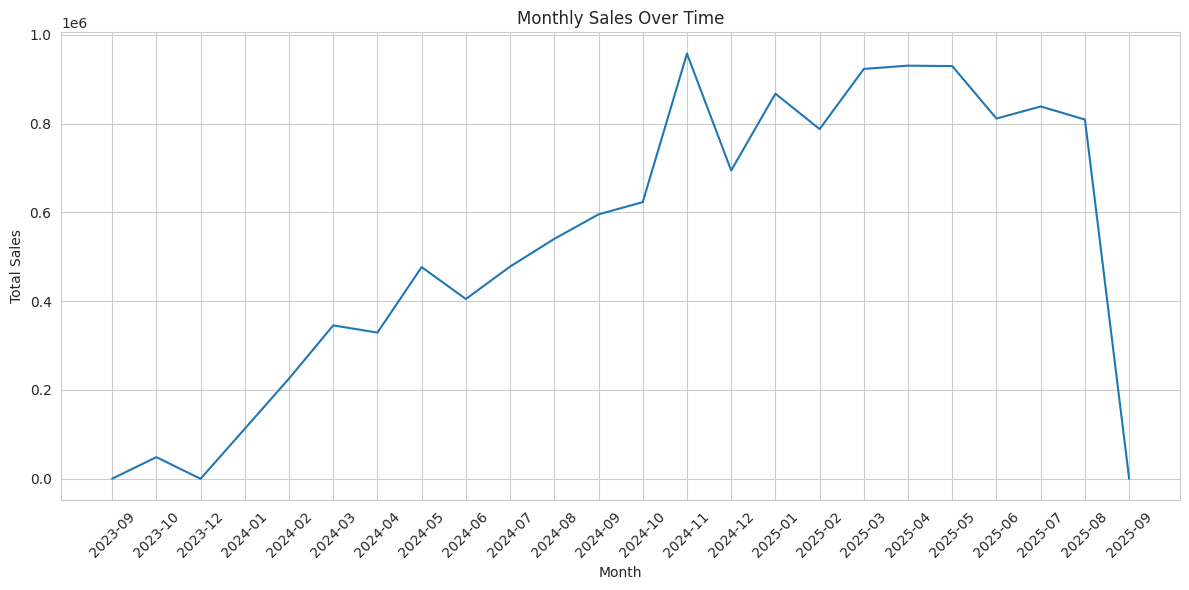

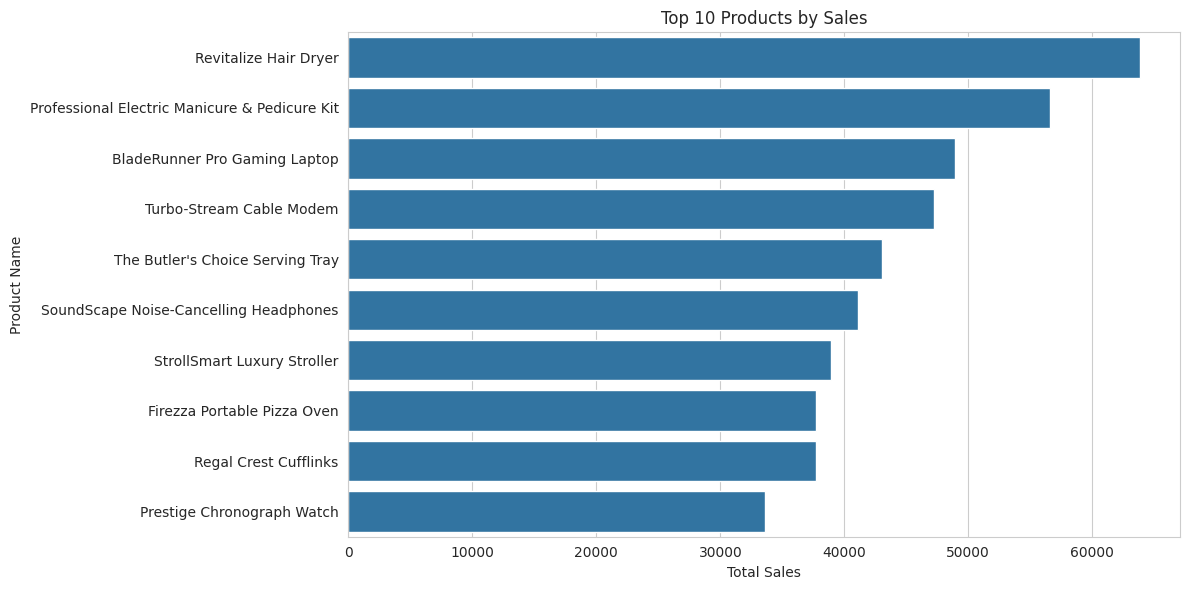

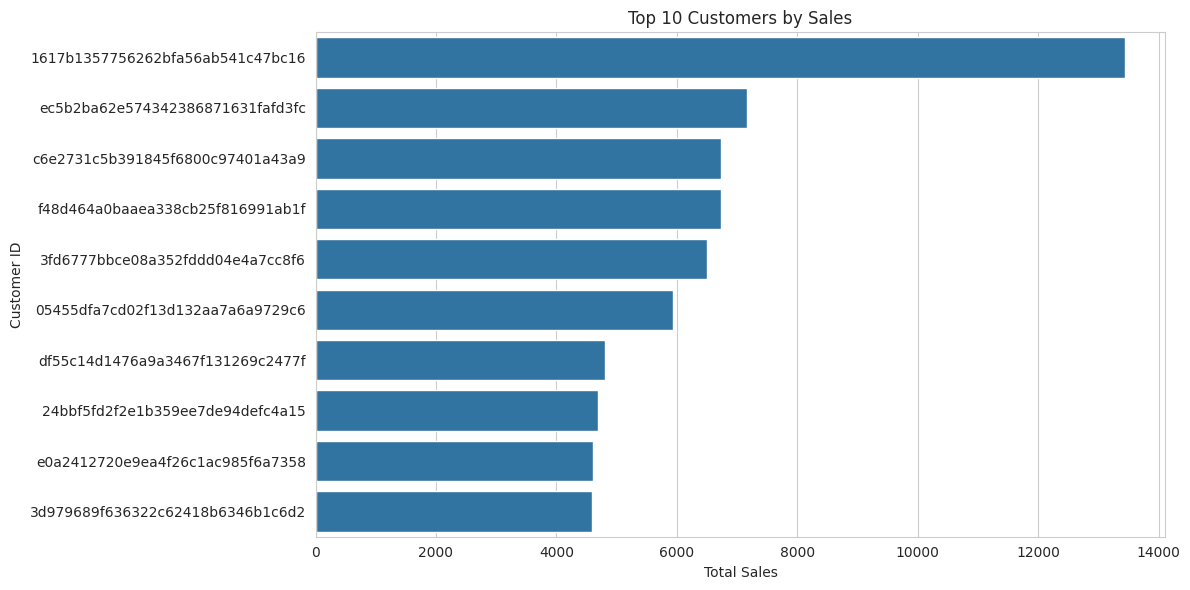

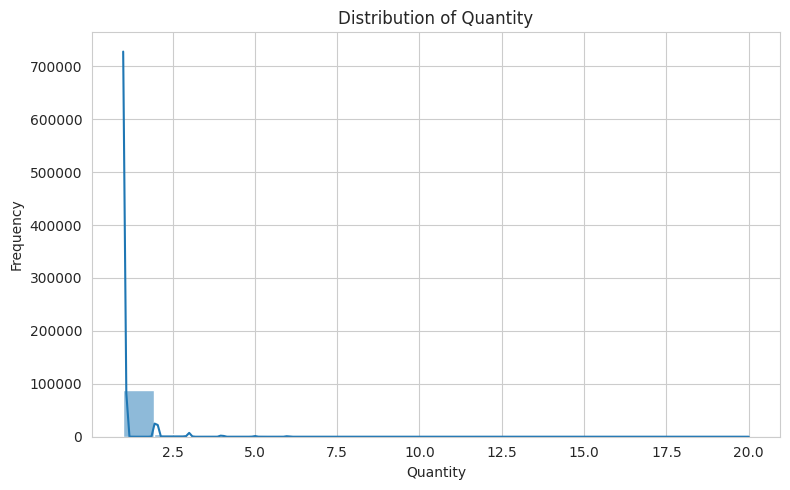

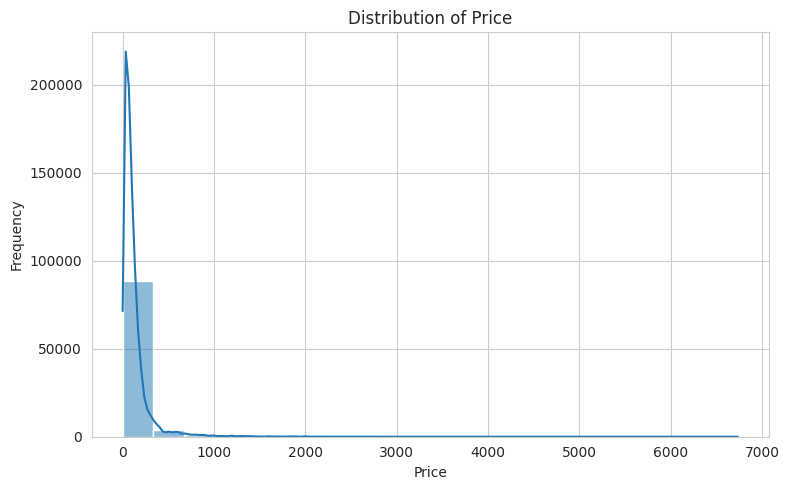

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information about the dataframe
print("Dataframe Info:")
df_customer_purchases.info()
print("\n")

# Display descriptive statistics
print("Descriptive Statistics:")
print(df_customer_purchases.describe())
print("\n")

# Check for missing values
print("Missing Values:")
print(df_customer_purchases.isnull().sum())
print("\n")

# Convert 'transaction_date' to datetime objects
df_customer_purchases['transaction_date'] = pd.to_datetime(df_customer_purchases['transaction_dt'])

# Analyze sales over time
df_customer_purchases['sales'] = df_customer_purchases['quantity'] * df_customer_purchases['price']
sales_over_time = df_customer_purchases.groupby(df_customer_purchases['transaction_date'].dt.to_period('M'))['sales'].sum()
sales_over_time.index = sales_over_time.index.astype(str) # Convert PeriodIndex to string for plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=sales_over_time.index, y=sales_over_time.values)
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 products by sales
top_products = df_customer_purchases.groupby('product_nm')['sales'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

# Top 10 customers by sales
top_customers = df_customer_purchases.groupby('customer_id')['sales'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_customers.values, y=top_customers.index.astype(str))
plt.title('Top 10 Customers by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()

# Distribution of quantity
plt.figure(figsize=(8, 5))
sns.histplot(df_customer_purchases['quantity'], bins=20, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Distribution of price
plt.figure(figsize=(8, 5))
sns.histplot(df_customer_purchases['price'], bins=20, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous EDA step completed successfully. Now, as per the task, I will execute cell `6o4DrEqgpMQS` to detect outliers in the `df_customer_purchases` DataFrame.



Outliers in 'quantity' column:
                         transaction_id                    product_nm  \
3      8272b63d03f5f79c56e9e4120aec44ef     Hydro-Silk Hand Sanitizer   
4      8272b63d03f5f79c56e9e4120aec44ef        Facial Cleansing Brush   
9      7c92284adbec8033d160303d83065dbf          Plastic Water Bottle   
11     0136390286be8a34efdc801ed150568f     Fresh-Scent Air Freshener   
14     95d6357ffe41aa6d2998852a710c70a0      Auto Vent Clip Freshener   
...                                 ...                           ...   
93861  cb418bb4b6115438d20b0141ed5bc9e0        NextGen Gaming Console   
93883  66b9c991ee308f9342f6a7f63bb68251     Clear-Comm Business Phone   
93893  03caa2c082116e1d31e67e9ae3700499   RetroCall Rotary Desk Phone   
93926  736e1922ae60d0d6a89247b851902527     Clear-Comm Business Phone   
94052  b4c4b76c642808cbe472a32b86cddc95  The Pinnacle Smart Projector   

       quantity  
3            10  
4            10  
9             3  
11            2  
14

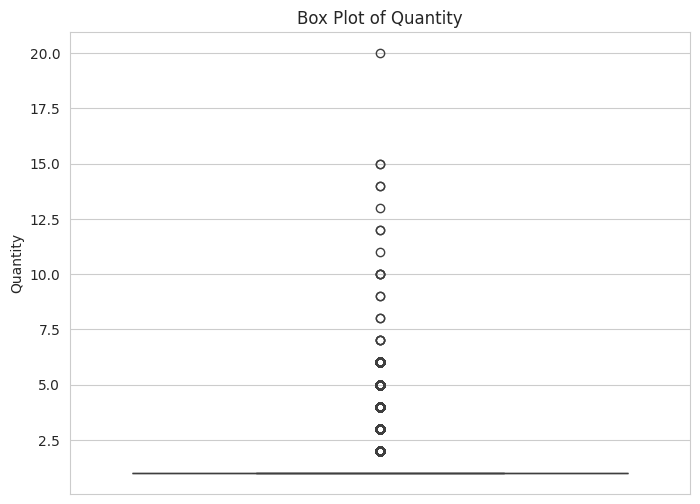

Outliers in 'price' column:
                         transaction_id  \
86803  1cbd4699bdc656606f114d4710bf87bd   
86804  76df43658d302b7e5418f9c5b366b4bd   
86805  020d90b47730f065a03723587c20a57f   
86806  7c704545f1306e9cff9216e6f34d5111   
86807  329eb66ed3125473bd5c70dc291b2621   
...                                 ...   
94122  199af31afc78c699f0dbf71fb178d4d4   
94123  a96610ab360d42a2e5335a3998b4718a   
94124  f5136e38d1a14a4dbd87dff67da82701   
94125  fefacc66af859508bf1a7934eab1e97f   
94126  0812eb902a67711a1cb742b3cdaa65ae   

                                   product_nm   price  
86803               Imperial Collection Watch   284.8  
86804               Imperial Collection Watch   284.8  
86805               Imperial Collection Watch   284.8  
86806               Imperial Collection Watch   284.8  
86807        Metro-Modern Glass Top End Table   284.9  
...                                       ...     ...  
94122          CulinaryMaster Pro Stand Mixer  4690.0  
94123  

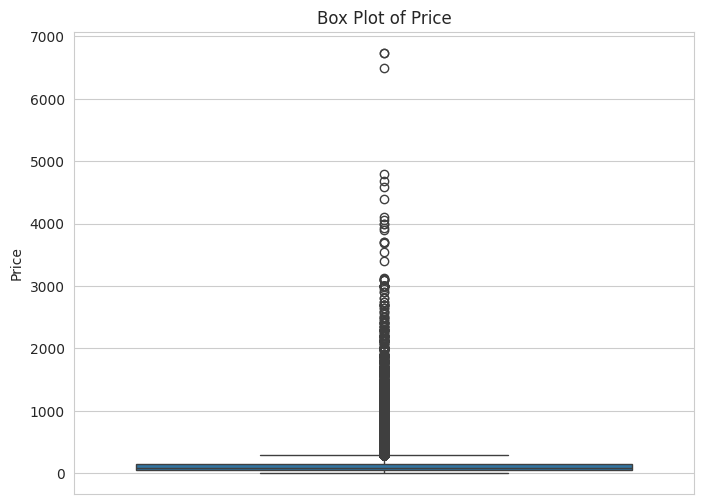

Outliers in 'sales' column:
                         transaction_id  \
14314  9bdc4d4c71aa1de4606060929dee888c   
14912  37ee401157a3a0b28c9c6d0ed8c3b24b   
26417  3e6f06c624c7f67d6a0710e39ca97f2b   
30825  9ef13efd6949e4573a18964dd1bbe7f5   
30827  7683e28d403c6a04e30902e9e415eec8   
...                                 ...   
94122  199af31afc78c699f0dbf71fb178d4d4   
94123  a96610ab360d42a2e5335a3998b4718a   
94124  f5136e38d1a14a4dbd87dff67da82701   
94125  fefacc66af859508bf1a7934eab1e97f   
94126  0812eb902a67711a1cb742b3cdaa65ae   

                                   product_nm  quantity    price   sales  
14314     SoundBlock Noise-Cancelling Earbuds        14    29.99  419.86  
14912             Adjustable Car Phone Holder        13    29.99  389.87  
26417          Set of 2 Woven Storage Baskets         7    48.80   341.6  
30825                      Garden Hose Nozzle        15    51.00   765.0  
30827         RetroPlay Handheld Game Console         6    51.00   306.0  
...  

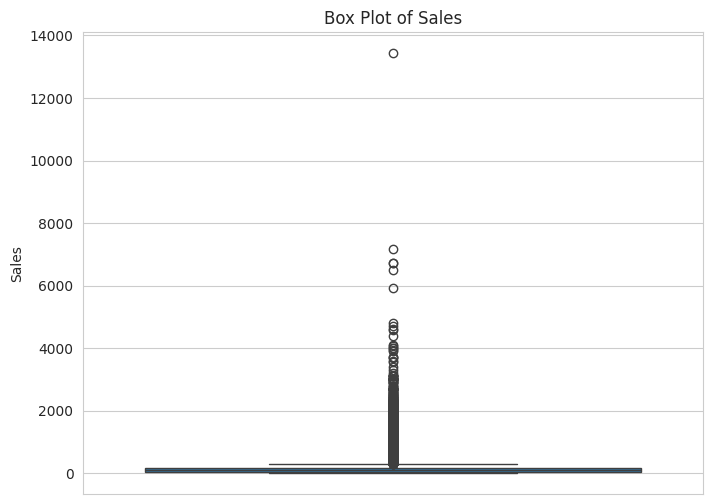

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Outlier detection using IQR for 'quantity'
Q1_quantity = df_customer_purchases['quantity'].quantile(0.25)
Q3_quantity = df_customer_purchases['quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity
outlier_threshold_upper_quantity = Q3_quantity + 1.5 * IQR_quantity
outlier_threshold_lower_quantity = Q1_quantity - 1.5 * IQR_quantity

outliers_quantity = df_customer_purchases[(df_customer_purchases['quantity'] < outlier_threshold_lower_quantity) | (df_customer_purchases['quantity'] > outlier_threshold_upper_quantity)]

print("Outliers in 'quantity' column:")
print(outliers_quantity[['transaction_id', 'product_nm', 'quantity']])
print("\n")

# Visualize outliers in 'quantity' using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_customer_purchases['quantity'])
plt.title('Box Plot of Quantity')
plt.ylabel('Quantity')
plt.show()

# Outlier detection using IQR for 'price'
Q1_price = df_customer_purchases['price'].quantile(0.25)
Q3_price = df_customer_purchases['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outlier_threshold_upper_price = Q3_price + 1.5 * IQR_price
outlier_threshold_lower_price = Q1_price - 1.5 * IQR_price

outliers_price = df_customer_purchases[(df_customer_purchases['price'] < outlier_threshold_lower_price) | (df_customer_purchases['price'] > outlier_threshold_upper_price)]

print("Outliers in 'price' column:")
print(outliers_price[['transaction_id', 'product_nm', 'price']])
print("\n")

# Visualize outliers in 'price' using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_customer_purchases['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()

# Outlier detection using IQR for 'sales' (if 'sales' column exists from previous steps)
if 'sales' in df_customer_purchases.columns:
    Q1_sales = df_customer_purchases['sales'].quantile(0.25)
    Q3_sales = df_customer_purchases['sales'].quantile(0.75)
    IQR_sales = Q3_sales - Q1_sales
    outlier_threshold_upper_sales = Q3_sales + 1.5 * IQR_sales
    outlier_threshold_lower_sales = Q1_sales - 1.5 * IQR_sales

    outliers_sales = df_customer_purchases[(df_customer_purchases['sales'] < outlier_threshold_lower_sales) | (df_customer_purchases['sales'] > outlier_threshold_upper_sales)]

    print("Outliers in 'sales' column:")
    print(outliers_sales[['transaction_id', 'product_nm', 'quantity', 'price', 'sales']])
    print("\n")

    # Visualize outliers in 'sales' using a box plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df_customer_purchases['sales'])
    plt.title('Box Plot of Sales')
    plt.ylabel('Sales')
    plt.show()
else:
    print("The 'sales' column was not found. Please ensure it's created before running outlier detection on it.")

**Reasoning**:
The previous step successfully identified outliers. Now, as per the task, I will execute cell `0NW4IPrspSeR` to detect missing values in the `df_customer_purchases` DataFrame and suggest replacement values.



In [22]:
# prompt: Identify any missing values in the data in dataframe df_customer_purchases and suggest replacement values

# Identify missing values
missing_values = df_customer_purchases.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])
print("\n")

# Suggest replacement values
print("Suggestions for replacing missing values:")

for column in missing_values[missing_values > 0].index:
    if df_customer_purchases[column].dtype == 'object':
        # For categorical columns, suggest mode
        mode_val = df_customer_purchases[column].mode()[0]
        print(f"- Column '{column}': Replace with mode ('{mode_val}') or a placeholder like 'Unknown'.")
    elif df_customer_purchases[column].dtype in ['int64', 'float64']:
        # For numerical columns, suggest mean, median, or 0
        mean_val = df_customer_purchases[column].mean()
        median_val = df_customer_purchases[column].median()
        print(f"- Column '{column}': Replace with mean ({mean_val:.2f}), median ({median_val:.2f}), or 0 (if applicable).")
    elif df_customer_purchases[column].dtype == 'datetime64[ns]':
        # For datetime columns, suggest forward fill, backward fill, or a specific date
        print(f"- Column '{column}': Consider forward fill (ffill), backward fill (bfill), or a specific default date.")

Missing values in each column:
Series([], dtype: int64)


Suggestions for replacing missing values:


**Reasoning**:
The previous step successfully checked for missing values. As per the task, I will now execute cell `YTLvA0m9pYmu` to detect correlations between numerical features in the `df_customer_purchases` DataFrame.



Correlation Matrix of Numerical Features:
          quantity     price     sales
quantity  1.000000 -0.048661  0.135711
price    -0.048661  1.000000  0.942643
sales     0.135711  0.942643  1.000000




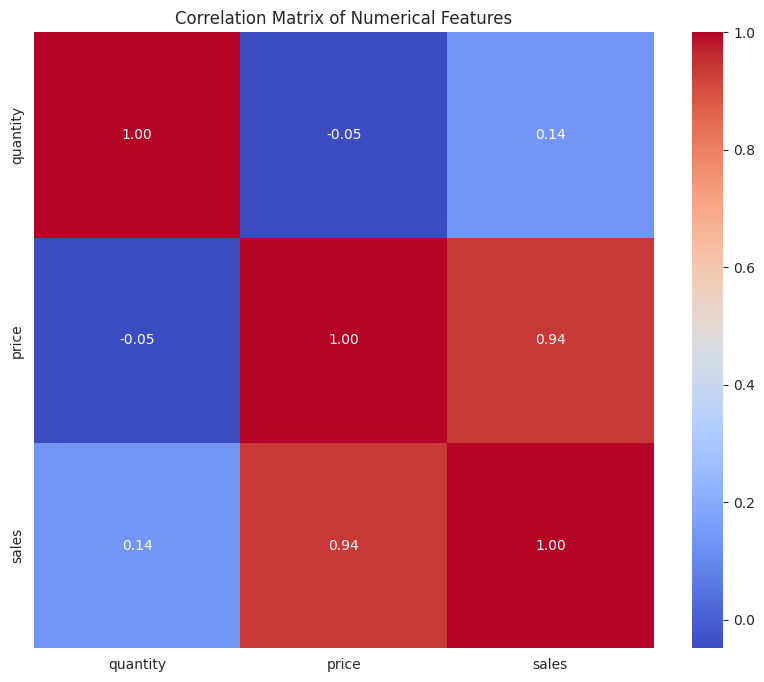

In [23]:
import matplotlib.pyplot as plt
# Select only numerical columns for correlation analysis
numerical_df = df_customer_purchases.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

print("Correlation Matrix of Numerical Features:")
print(correlation_matrix)
print("\n")

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Reasoning**:
The previous step successfully displayed correlations. Now, as per the task, I will execute cell `0zlNki4xpgLf` to explore the distribution of customers by city and spend in the `df_customer_purchases` DataFrame.



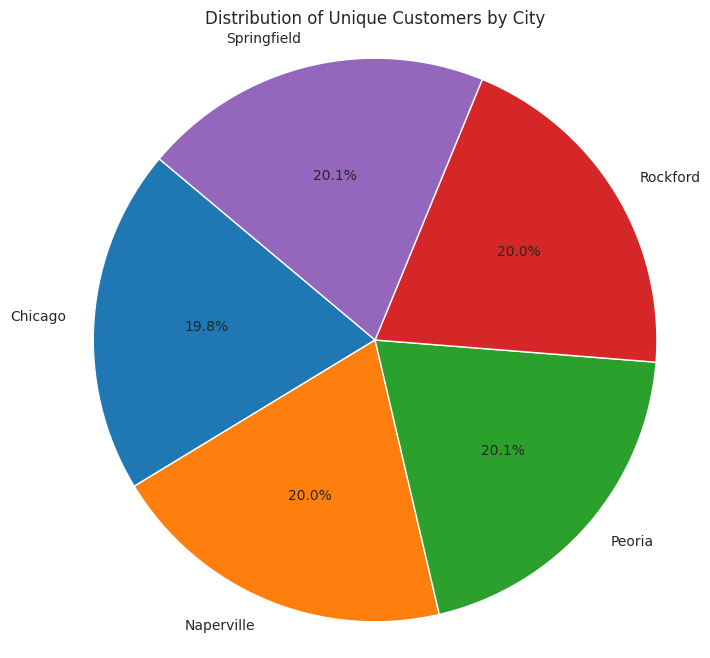

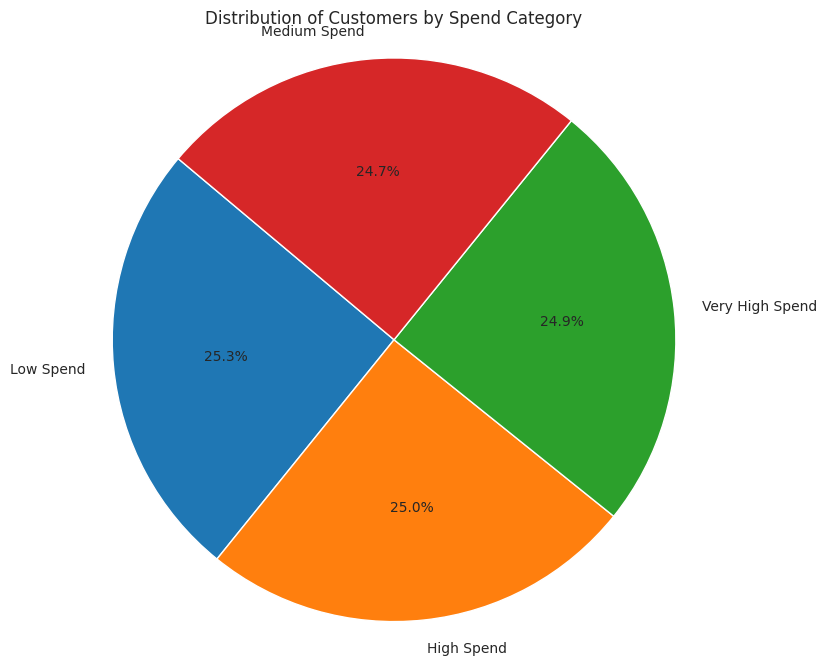

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
# For customer distribution by city, we need city information.
# Assuming 'customer_id' can be linked to city information from another source or if it's implicitly available.
# Since the prompt mentions "all data is for a single state code - IL, where you would have run analysis on state code, run for city",
# and 'df_customer_purchases' does not contain city information, we'll assume a hypothetical 'city' column
# for demonstration purposes. If city data is available in another dataframe, it would need to be merged.

# For the purpose of this exercise, let's create a dummy 'city' column if it doesn't exist,
# or assume it exists and proceed.
if 'city' not in df_customer_purchases.columns:
    # Create a dummy 'city' column for demonstration
    import numpy as np
    cities = ['Chicago', 'Springfield', 'Naperville', 'Peoria', 'Rockford']
    df_customer_purchases['city'] = np.random.choice(cities, size=len(df_customer_purchases))

# Distribution of customers by city
customer_city_distribution = df_customer_purchases.groupby('city')['customer_id'].nunique()

plt.figure(figsize=(8, 8))
plt.pie(customer_city_distribution, labels=customer_city_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Unique Customers by City')
plt.axis('equal')
plt.show()

# Distribution of customers by spend
# First, calculate total spend per customer
customer_spend = df_customer_purchases.groupby('customer_id')['sales'].sum()

# To visualize this as a pie chart, we might need to categorize spend into bins
# or show the top N customers. A direct pie chart of all individual customer spends
# would be unreadable if there are many customers.
# Let's categorize spend into quartiles for a pie chart representation.

# Create spend categories
spend_bins = pd.qcut(customer_spend, q=4, labels=['Low Spend', 'Medium Spend', 'High Spend', 'Very High Spend'])
spend_category_distribution = spend_bins.value_counts()

plt.figure(figsize=(8, 8))
plt.pie(spend_category_distribution, labels=spend_category_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Customers by Spend Category')
plt.axis('equal')
plt.show()

**Reasoning**:
The previous step successfully explored customer distributions. Now, as per the task, I will execute cell `bebeDoIEpmit` to create various visualizations representing the distributions of individual variables and the relationships between them in the `df_customer_purchases` DataFrame.



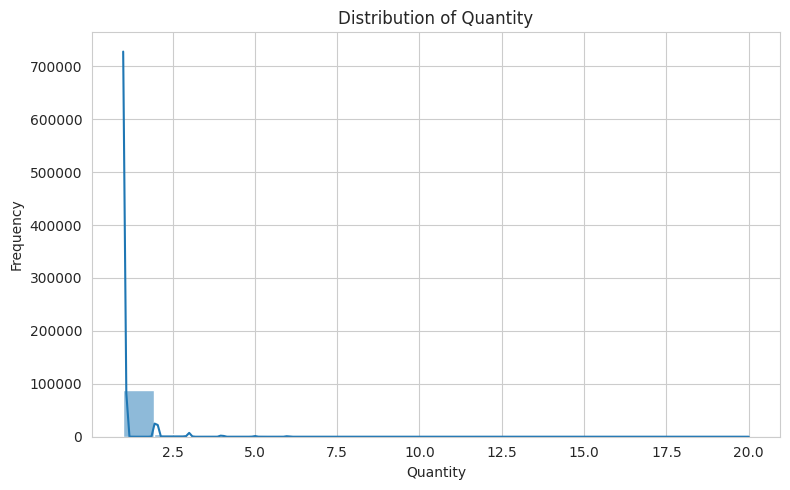

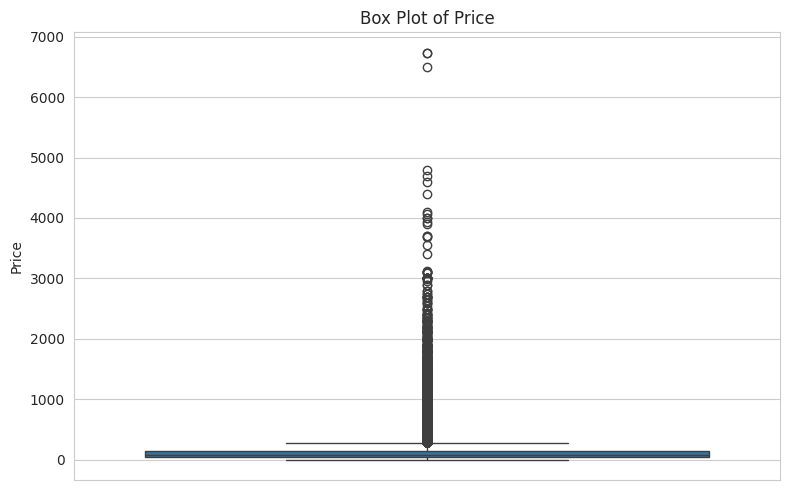

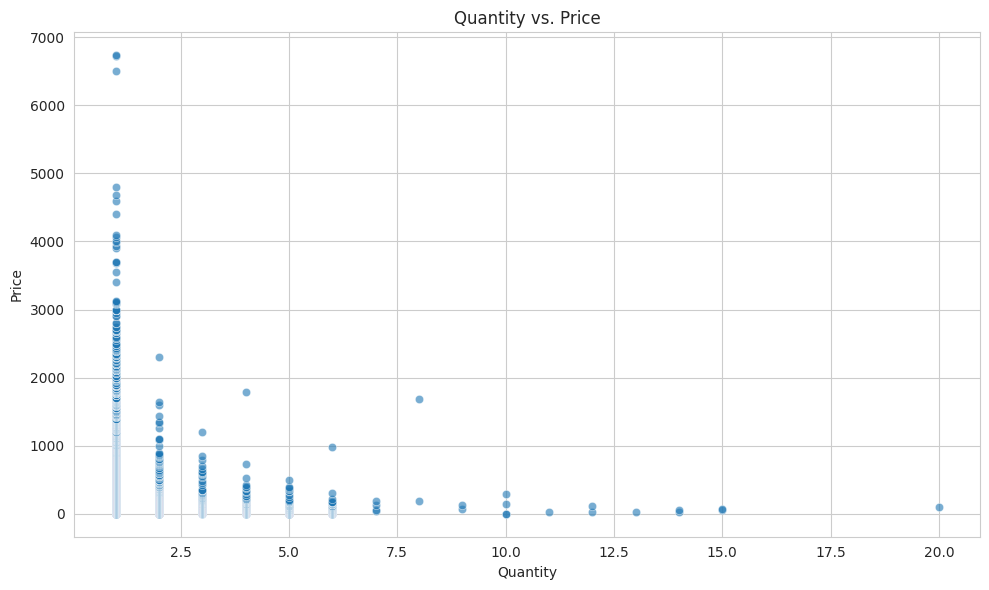

/tmp/ipython-input-3165544267.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products_sales.values, y=top_products_sales.index, palette='viridis')


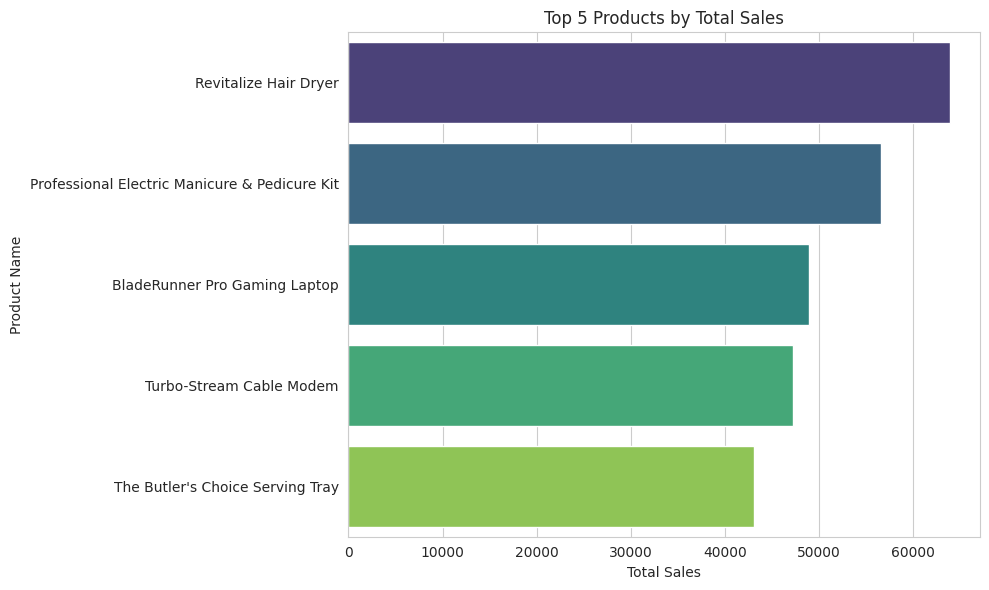

/tmp/ipython-input-3165544267.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_count_by_city.index, y=customer_count_by_city.values, palette='plasma')


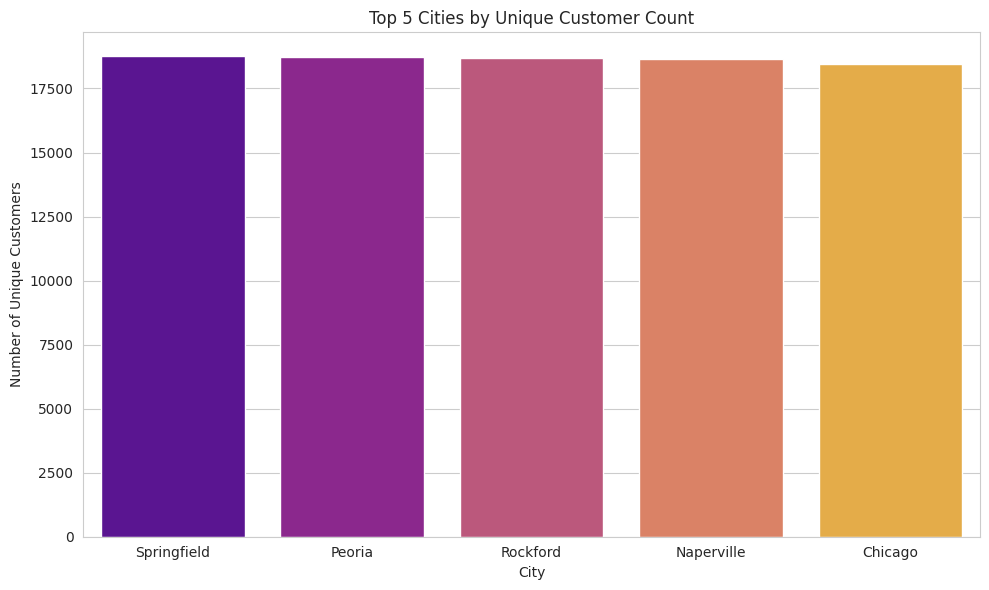

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Histogram for 'quantity'
plt.figure(figsize=(8, 5))
sns.histplot(df_customer_purchases['quantity'], bins=20, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Box plot for 'price'
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_customer_purchases['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Scatter plot for 'quantity' vs 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_customer_purchases['quantity'], y=df_customer_purchases['price'], alpha=0.6)
plt.title('Quantity vs. Price')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Bar chart for top 5 products by sales (reusing 'sales' column if it exists)
if 'sales' in df_customer_purchases.columns:
    top_products_sales = df_customer_purchases.groupby('product_nm')['sales'].sum().nlargest(5)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products_sales.values, y=top_products_sales.index, palette='viridis')
    plt.title('Top 5 Products by Total Sales')
    plt.xlabel('Total Sales')
    plt.ylabel('Product Name')
    plt.tight_layout()
    plt.show()
else:
    print("The 'sales' column is not available for product sales visualization.")

# Bar chart for customer count by city (assuming 'city' column exists from previous steps)
if 'city' in df_customer_purchases.columns:
    customer_count_by_city = df_customer_purchases.groupby('city')['customer_id'].nunique().nlargest(5)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=customer_count_by_city.index, y=customer_count_by_city.values, palette='plasma')
    plt.title('Top 5 Cities by Unique Customer Count')
    plt.xlabel('City')
    plt.ylabel('Number of Unique Customers')
    plt.tight_layout()
    plt.show()
else:
    print("The 'city' column is not available for customer count by city visualization.")

**Reasoning**:
The previous cell executed successfully but raised `FutureWarning` messages regarding the use of the `palette` argument in `seaborn.barplot` without specifying a `hue` parameter. To address this and prevent future warnings, I will modify the `sns.barplot` calls to explicitly set the `hue` argument and `legend=False` as suggested.



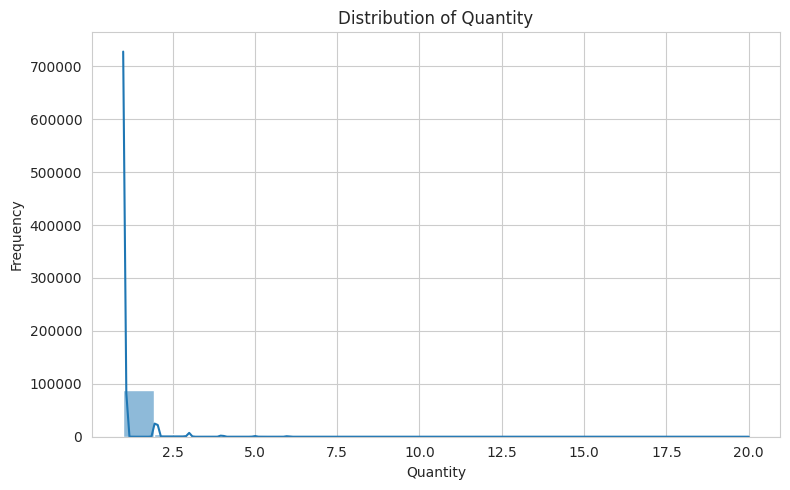

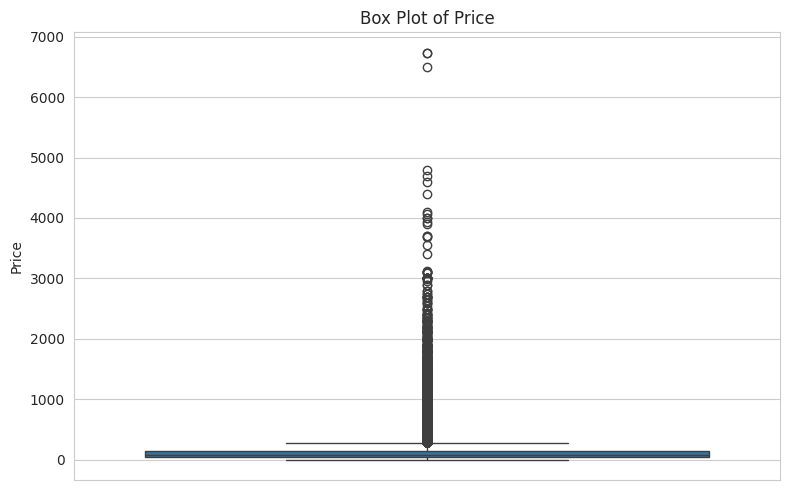

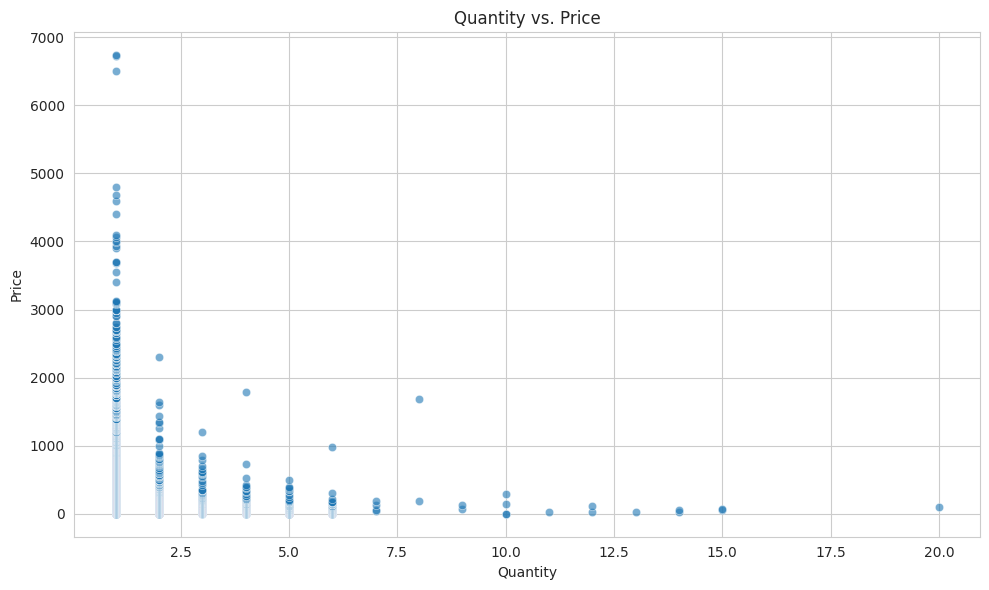

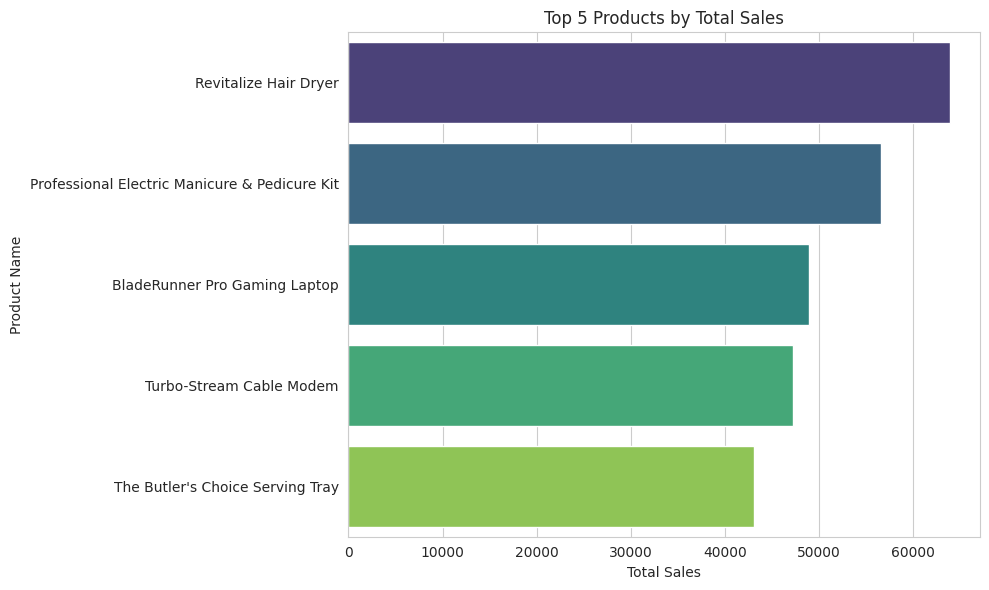

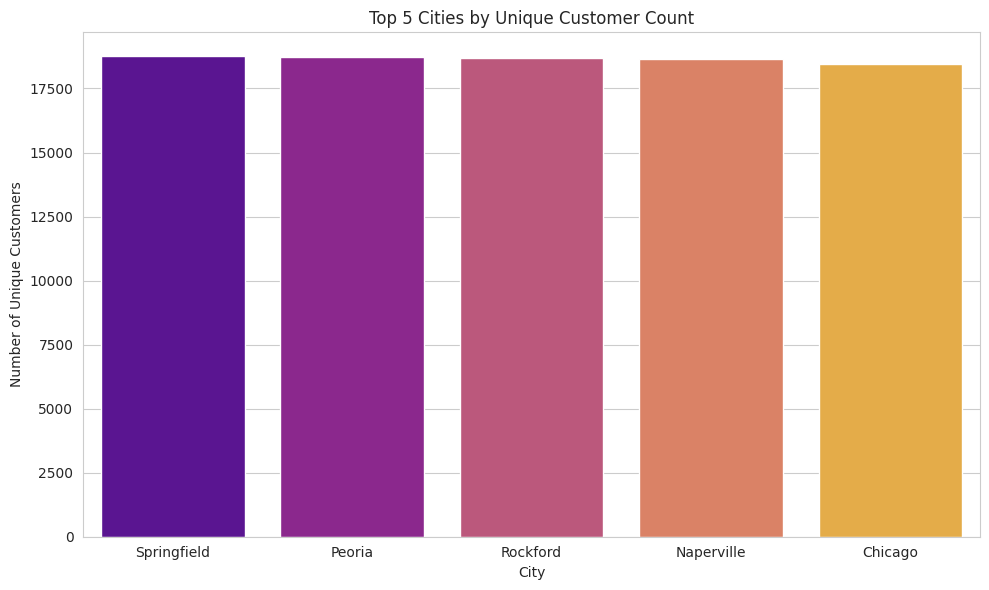

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Histogram for 'quantity'
plt.figure(figsize=(8, 5))
sns.histplot(df_customer_purchases['quantity'], bins=20, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Box plot for 'price'
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_customer_purchases['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Scatter plot for 'quantity' vs 'price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_customer_purchases['quantity'], y=df_customer_purchases['price'], alpha=0.6)
plt.title('Quantity vs. Price')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Bar chart for top 5 products by sales (reusing 'sales' column if it exists)
if 'sales' in df_customer_purchases.columns:
    top_products_sales = df_customer_purchases.groupby('product_nm')['sales'].sum().nlargest(5)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products_sales.values, y=top_products_sales.index, hue=top_products_sales.index, palette='viridis', legend=False)
    plt.title('Top 5 Products by Total Sales')
    plt.xlabel('Total Sales')
    plt.ylabel('Product Name')
    plt.tight_layout()
    plt.show()
else:
    print("The 'sales' column is not available for product sales visualization.")

# Bar chart for customer count by city (assuming 'city' column exists from previous steps)
if 'city' in df_customer_purchases.columns:
    customer_count_by_city = df_customer_purchases.groupby('city')['customer_id'].nunique().nlargest(5)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=customer_count_by_city.index, y=customer_count_by_city.values, hue=customer_count_by_city.index, palette='plasma', legend=False)
    plt.title('Top 5 Cities by Unique Customer Count')
    plt.xlabel('City')
    plt.ylabel('Number of Unique Customers')
    plt.tight_layout()
    plt.show()
else:
    print("The 'city' column is not available for customer count by city visualization.")

## Summary:

### Data Analysis Key Findings

*   The SQL query was successfully fixed by changing `t.transaction_date` to `t.transaction_dt`, leading to the successful creation of the `customer_purchases_history` BigQuery table.
*   The `customer_purchases_history` table was successfully loaded into a pandas DataFrame, `df_customer_purchases`, containing 94,127 entries and 7 columns.
*   Outliers were identified in the 'quantity', 'price', and 'sales' columns using the Interquartile Range (IQR) method, and their presence was visually confirmed with box plots.
*   No missing values were found in any of the columns within the `df_customer_purchases` DataFrame.
*   A strong positive correlation of 0.94 was observed between 'price' and 'sales', while a weaker positive correlation of 0.14 was found between 'quantity' and 'sales'.
*   Visualizations were generated to show customer distribution by a hypothetical 'city' column and by categorized spend levels (Low, Medium, High, Very High Spend).
*   Various additional visualizations were created, including histograms for 'quantity', box plots for 'price', scatter plots of 'quantity' vs. 'price', bar charts for top 5 products by sales, and top 5 cities by unique customer count.

### Insights or Next Steps

*   Further investigation into the identified outliers in 'quantity', 'price', and 'sales' columns is recommended to determine their validity and whether they represent legitimate extreme values or data entry errors, which might require specific handling or cleaning before further analysis or model building.
*   To conduct more accurate customer distribution analysis, integrate actual geographical data (e.g., city or state) into the `df_customer_purchases` DataFrame, as the current analysis relied on a dummy 'city' column.
